# Fairness Auditor - Evaluating Bias Mitigation Algorithms

This notebook includes the template for processing the data, training a Machine Learning model, applying a bias mitigation algorithm and presenting the utility/fairness results.

Key definitions (simplified):
* **Dataset:** A dataset includes a set of rows and columns. The rows correspond to the various records of the dataset. The columns are composed of: (a) Outcome: The column which we are trying to predict using a Machine Learning algorithm and (b) Features: The columns which are used to predict the outcome.
* **Protected attribute:** Some of the features, are referred to as protected attributes if they should not be used to decide whether someone should get a specific outcome or the other. For example, whether someone receives a loan or not (getting a loan is the outcome here), it should not depend on whether they are Male or Female but rather their financial standing.
* **Covariates:** Protected attributes are referred as covariates in the healthcare domain where such features play an important role in outcome prediction. For example, the likelihood of someone getting a breast cancer is much higher if the individual is a Female than when they are Male.
* **Fairness:** While there are several definitions of fairness, the overwhelming idea is that different groups as defined by protected attribute should not be treated differently, thus, should not be discriminated against.

## Import libraries

Import required libraries for working with dataset files and performing processing of the data.

In [16]:
# Filter all warnings (from libraries)
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings("ignore")

# Data processing, hanling and saving
## Numpy enables handling of arrays (lists) efficiently
import numpy as np
## Pandas is used for dataframe handling, loading and saving
import pandas as pd

# Visualization
## Matpltolib for basic visualizations
import matplotlib.pyplot as plt
## Seaborn for advanced visualizations
import seaborn as sns

# Scikit-learn
## LabelEncoder converts a categorical column to numerical columns (e.g. A, B, C to 0, 1, 2)
from sklearn.preprocessing import LabelEncoder
## OneHotEncoder converts a categorical column to multiple columns with values
## 0 (where the value is missing) and 1 (where the value is present)
from sklearn.preprocessing import OneHotEncoder
## Split a given dataset into train-test
from sklearn.model_selection import train_test_split
## Training of a Random Forest model
from sklearn.ensemble import RandomForestClassifier
## Evaluating the model using balanced accuracy metric
from sklearn.metrics import balanced_accuracy_score

# AIF-360
## Used to create a form of dataframe used by AIF-360
from aif360.metrics import ClassificationMetric
from aif360.datasets import StandardDataset, BinaryLabelDataset
## Bias mitigation algorithm - Reweighing
from aif360.algorithms.preprocessing import Reweighing

## Process data

The dataset needs to be processed before it can be used for analysis. This can be based on prior knowledge, domain expertise or literature.

In [2]:
# Read data and name the variable as data
filename = "data/dataset.csv"
data = pd.read_csv(filename)

# Convert marital-status to simpler categories
data["marital-status"] = data["marital-status"].replace(["Never-married", "Divorced", 
                                                         "Separated", "Widowed"], 
                                                        "Single")
data["marital-status"] = data["marital-status"].replace(["Married-civ-spouse",
                                                         "Married-spouse-absent",
                                                         "Married-AF-spouse"], 
                                                        "Married")
# Convert categorical columns to numerical and change to integer
# (Can also be done using LabelEncoder)
data["marital-status"] = data["marital-status"].map({"Married": 1, "Single": 0})
data["marital-status"] = data["marital-status"].astype(int)

# Convert "?" (missing values) to Nan using np.nan
# Nan - Not a number
data["native-country"] = data["native-country"].replace('?', np.nan)
data["workclass"] = data["workclass"].replace('?', np.nan)
data["occupation"] = data["occupation"].replace('?', np.nan)

# Drop Nan values from all columns 
data.dropna(how = "any", inplace = True)

# Drop columns not be used in this specific analysis
data.drop(labels = ["education", "age", "hours-per-week", "fnlwgt", 
                    "capital-gain", "capital-loss", "native-country"], axis = 1, inplace = True)

# Convert categorical columns to numberical and then change to integer type
data["gender"] = data["gender"].map({"Female": 0, "Male": 1}).astype(int) # Protected attribute
data["income"] = data["income"].map({"<=50K": 0, ">50K": 1}).astype(int) # Outcome variable

# Convert specific categorical columns using one hot encoding
ordered_one_hot_encoders = []
for col in ["workclass", "occupation", "relationship", "race"]:

    # Get One Hot Encoder
    oneHotEncoder = OneHotEncoder()
    values = data[col].values.reshape(-1, 1)

    # Train Encoder and save it
    oneHotEncoder.fit(values)
    ordered_one_hot_encoders.append(oneHotEncoder)

    # Add column to dataframe
    data[oneHotEncoder.categories_[0]] = oneHotEncoder.transform(values).toarray().astype(int)

    # Remove first column and initial category
    data = data.drop([oneHotEncoder.categories_[0][0]], axis = 1)
    data = data.drop([col], axis = 1)

# Save the processed data to a new file
saved_filename = "data/processed_dataset.csv"
data.to_csv(saved_filename, index = False)

## Train and evaluating Utility-Fairness

The data is used for training a Random Forest model along with evaluation of utility and fairness.

Key definitions (simplified):
* **Utility metric:** A metric used for evaluating the performance or score of a Machine Learning model on the test data. Here, utility metric is set to Balanced Accuracy.
* **Fairness metric:** A metric used for evaluating the bias in a Machine Learning model's prediction. Here, fairness metric is set to (a) Average Odds Difference, (b) Equal Opportunity Difference and (c) Equalized Odds.

Here, we use *Gender* as the protected attribute.

### Fairness function

Function that returns the fairness scores.

In [6]:
def get_fairness(test, label_col, protected_attrs, y_test_pred, unprivileged_groups, privileged_groups):
    
    # Create dataset for use in AIF360 library
    test = BinaryLabelDataset(df = test, label_names = [label_col], 
                              protected_attribute_names = protected_attrs,
                              favorable_label = 1, unfavorable_label = 0)
    
    # Combine the predictions with the data
    test_pred = test.copy()
    test_pred.labels = y_test_pred
    
    # Get fairness scores
    metric = ClassificationMetric(test, test_pred, 
                                  unprivileged_groups = unprivileged_groups,
                                  privileged_groups = privileged_groups)

    # Attach results to a list
    fairness_results = []
    fairness_results.append(metric.average_odds_difference()) # Average Odds Difference
    fairness_results.append(metric.equal_opportunity_difference()) # Equal Opportunity Difference
    fairness_results.append(max(abs(metric.true_positive_rate_difference()), 
                                abs(metric.false_positive_rate_difference()))) # Equalized Odds
    
    # Return results
    return fairness_results

### Baseline

Training a Random Forest model without any bias mitigation algorithm. This is referred as *Baseline*.

In [11]:
# Get features and labels
X = data.drop(["income"], axis = 1)
y = data["income"]

# Split into train-test set to 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size = 0.30, 
                                                    random_state = 0)

# Create model and train it
model = RandomForestClassifier(random_state = 0, n_jobs = -1)
model.fit(X_train, y_train)

# Make prediction
y_test_pred = model.predict(X_test)

# Get fairness results
X_test.loc[:, "income"] = y_test
avg_ods, eq_opp, equalized_odds = get_fairness(X_test, 
                                               "income", 
                                               ["gender"], 
                                               y_test_pred, 
                                               [{"gender": 0}], 
                                               [{"gender": 1}])

# Create dataframe
baseline_scores_df = pd.DataFrame({"Test Balanced Accuracy": balanced_accuracy_score(y_test, y_test_pred),
                                   "Average Odds Difference": avg_ods,
                                   "Equal Opportunity Difference": eq_opp,
                                   "Equalized Odds": equalized_odds}, index = [0])

# Output scores
baseline_scores_df

,Test Balanced Accuracy,Average Odds Difference,Equal Opportunity Difference,Equalized Odds
0,0.729543,-0.125034,-0.153869,0.153869


### Reweighing

Training a Random Forest model without **reweighing** bias mitigation algorithm. This is referred as *Reweighing*.

In [14]:
# Get features and labels
X = data.drop(["income"], axis = 1)
y = data["income"]

# Split into train-test set to 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size = 0.30, 
                                                    random_state = 0)

# Create model and train it
model = RandomForestClassifier(random_state = 0, n_jobs = -1)
# Reweighing
train = X_train.copy()
train.loc[:, "income"] = y_train
train = BinaryLabelDataset(df = train, label_names = ["income"], 
                           protected_attribute_names = ["gender"],
                           favorable_label = 1, unfavorable_label = 0)

# Reweighing
rw = Reweighing(unprivileged_groups = [{"gender": 0}], 
                     privileged_groups = [{"gender": 1}])
rw.fit(train)
train = rw.transform(train)
model.fit(X_train, y_train, sample_weight = train.instance_weights)

# Make prediction
y_test_pred = model.predict(X_test)

# Get fairness results
X_test.loc[:, "income"] = y_test
avg_ods, eq_opp, equalized_odds = get_fairness(X_test, 
                                               "income", 
                                               ["gender"], 
                                               y_test_pred, 
                                               [{"gender": 0}], 
                                               [{"gender": 1}])

# Create dataframe
reweighing_scores_df = pd.DataFrame({"Test Balanced Accuracy": balanced_accuracy_score(y_test, y_test_pred),
                                   "Average Odds Difference": avg_ods,
                                   "Equal Opportunity Difference": eq_opp,
                                   "Equalized Odds": equalized_odds}, index = [0])

# Output scores
reweighing_scores_df

,Test Balanced Accuracy,Average Odds Difference,Equal Opportunity Difference,Equalized Odds
0,0.711146,-0.002877,0.037289,0.043044


## Comparing scores

The scores achieved by the two models are compared using box plots.

''

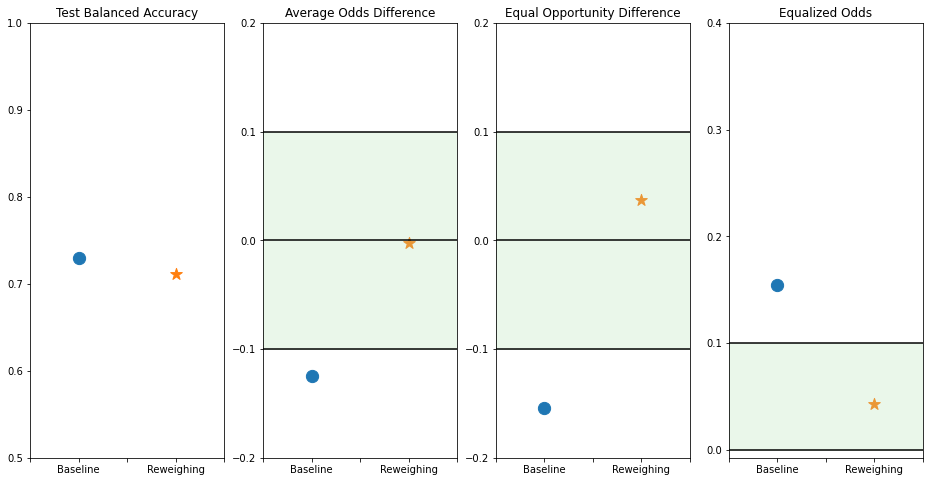

In [54]:
# Create 4 plots
fig, ax = plt.subplots(1, 4, figsize = (16, 8))

# For Average Odds Difference (fairness region)
ax[1].axhline(-0.1, color = "black")
ax[1].axhline(0.0, color = "black")
ax[1].axhline(0.1, color = "black")
ax[1].axhspan(-0.1, 0.1, alpha = 0.25, color = "#AFE1AF")

# For Equal Opportunity Difference (fairness region)
ax[2].axhline(-0.1, color = "black")
ax[2].axhline(0.0, color = "black")
ax[2].axhline(0.1, color = "black")
ax[2].axhspan(-0.1, 0.1, alpha = 0.25, color = "#AFE1AF")

# For Equalized Odds (fairness region)
ax[3].axhline(0.0, color = "black")
ax[3].axhline(0.1, color = "black") 
ax[3].axhspan(0.0, 0.1, alpha = 0.25, color = "#AFE1AF")

# Plot the values
for i, metric in enumerate(baseline_scores_df.columns):
    ax[i].scatter([0], [baseline_scores_df[metric]], marker = "o", s = 150)
    ax[i].scatter([1], [reweighing_scores_df[metric]], marker = "*", s = 150)
    
    # Update x-axis ticks
    ax[i].set_xticks([-0.5, 0, 0.5, 1, 1.5]) 
    ax[i].set_xticklabels(["", "Baseline", "", "Reweighing", ""])
    
    # Update title
    ax[i].set_title(metric)
    
# Update y-axis ticks
ax[0].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
ax[2].set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
ax[3].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
;

From the results, we can conclude that *Baseline* has better utility score than *Reweighing*. However, as measured by the three fairness metrics, the *Reweighing* scores are inside the region of fairness while *Baseline* scores are not.